## Oscar Fuentes  
### Tutor:Jesús Savage

HMM SLAM ( FUERA DE LINEA IMPLEMENTACION BAWUM WELCH EM APROX.)

In [1]:
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import  MiniBatchKMeans
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
%autosave 0 

Autosave disabled


# Definiciones  y funciones auxliares para HMM

In [2]:




class HMM (object):
             def __init__(self,A,B,PI):
                 self.A=A
                 self.B=B
                 self.PI=PI   
def cuantizar_xy(xy, cc):
    xycuant=cc
    out=np.power(xycuant-xy,2).sum(axis=1).argmin()
    return out
    
def path_to_xy(path,ccxy):
    estimated= pd.DataFrame(path.astype(int).T)
    estimated.columns=['Path_vit']
    estimated['xcuant'] = estimated['Path_vit'].apply(lambda x: ccxy[x,0])
    estimated['ycuant'] = estimated['Path_vit'].apply(lambda x: ccxy[x,1])                                
    return (estimated)
def quantized(xyth,ccxyth):
    xythcuant=np.argmin(np.linalg.norm(xyth-ccxyth,axis=1))
    x,y=ccxyth[xythcuant,:2]
    return ((x,y),(xythcuant))


#### VITERBI

def viterbi(obs,Modelo1,PI):
    A, B= Modelo1.A , Modelo1.B
    
    delta=np.zeros((len(obs)+1,len(Modelo1.A)))
    phi=np.zeros((len(obs)+1,len(A)))+666
    path =np.zeros(len(obs)+1)
    T=len(obs)
    Modelo1.PI = PI
    delta[0,:]= Modelo1.PI * Modelo1.B[:,obs[0]]
    phi[0,:]=666
    for t in range(len(obs)):
        for j in range(delta.shape[1]):

            delta [t+1,j]=np.max(delta[t] * A[:,j]) * B[j,obs[t]]
            phi[t+1,j]= np.argmax(delta[t] * A[:,j])
    path[T]=int(np.argmax(delta[T,:]))
    for i in np.arange(T-1,0,-1):
        #print (i,phi[i+1,int(path[i+1])])
        path[i]=phi[i+1,int(path[i+1])]
    return(path)



In [3]:
def Markov_A_2_grafo(A,ccxyth):
    dists=np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range (A.shape[1]):
            if A[i,j]!=0 :
                dists[i,j]= np.linalg.norm(ccxyth[i]-ccxyth[j])    
    
    
    con = np.where(dists==0,np.inf,dists)
    graphe2=grafo(ccxyth,con)
    return graphe2


class node(object):
    def __init__(self,x,y):
        self.x=x
        self.y=y
        
        
class grafo (object):
             def __init__(self,nodos,conec):
                 self.nodos=nodos
                 self.conec=conec        

                    
                    
### DIJSKTRA   ( perfectamente podría USARSE A * , pero dada la baja complejidad del grafo no parece justificar )

def dijkstra(nodoinicial,nodofinal,graphe):
    

    numnodos= len(graphe.nodos)
    con = graphe.conec
    D= np.ones(numnodos)*np.inf
    Prv= np.ones(numnodos)*np.inf
    V= np.zeros(numnodos)
    a = nodoinicial
    D[a]=0
    Prv[a]=0
    Prv[np.where(con[a]!=np.inf)]=a
    V[a]=1
    Dacc=D[a]
    ########
    D=np.minimum(D,con[a]+D[a])
    cont=0
    sucess=False
    while(sucess==False):
        a = np.argmin(D+np.where (V==1,np.inf, V))
        Dacc=D[a]
        Prv[np.where(D>(con[a]+Dacc) )]=a
        V[a]=1
        D=np.minimum(D,con[a]+Dacc)
        if (a== nodofinal):
            print("RUTA CALCULADA ")
            sucess=True
    rutainv=[]
    rutainv.append(nodofinal)
    while(rutainv[-1]!=nodoinicial):
        prv=Prv[int(rutainv[-1])]
        rutainv.append(prv)

    ruta=[]
    for n in reversed(rutainv):
        ruta.append(n)
    return(ruta)

def plot_cc_arrow(cc):
    fig=plt.figure(figsize=(10,10))
    for c in cc:
        ang=c[2]*180/math.pi
        

        plt.plot(c[0], c[1], marker=(3, 1,ang ), markersize=10,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2]+math.pi/2)), c[1]-(.01*np.sin(c[2]+math.pi/2)), marker=(1, 1,ang), markersize=25,c='green', linestyle='--')

    #plt.xlim([0,4])
    #plt.ylim([0,4])

    plt.show()

# Leer y acondicionar DATA SET de un txt separado por comas
## Se usa DATAFRAMES (Pandas)
### el data set es una muestra sintética obtenida de simulación   (Mínimo Rodamiento ODOMETRÏA RUEDA)
### Se supone ideal

#### data set disponible en 

In [4]:

data=pd.read_csv('datasets/lecs_odom(goodman).txt')

#data=data2
#data=data.iloc[:30000,:]

cols=['x','y','theta']
n_reads=data.shape[1]-3
n_reads
etiquetas=[]
for i in range (n_reads):
    etiquetas.append('R'+str(i))

        
for lab in cols:
    etiquetas.append(lab)
data.columns=etiquetas

data.describe()



##### DATA CLIP PARA QUITAR NAN'S  propios del LASERSCAN msg

xyth=data[['x','y','theta']]

lecs=data.iloc[:,0:n_reads]
lecs=np.clip(lecs,0,5)
data.iloc[:,0:n_reads]=lecs

data.describe()



,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R714,R715,R716,R717,R718,R719,R720,x,y,theta
count,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,...,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000,14136.000000
mean,1.968981,1.974375,1.974785,1.974469,1.973830,1.971698,1.969295,1.968657,1.965194,1.964131,...,1.844058,1.843981,1.846350,1.847477,1.848528,1.849610,1.850703,1.356175,2.452435,0.144713
std,1.049878,1.057772,1.059869,1.061713,1.061752,1.060802,1.059844,1.060608,1.059701,1.059111,...,0.935262,0.933657,0.937424,0.940018,0.941696,0.944158,0.946312,0.774155,1.350172,1.878428
min,0.426443,0.426465,0.426445,0.424923,0.424836,0.424520,0.423348,0.423476,0.422594,0.422392,...,0.391625,0.363851,0.359515,0.355293,0.351181,0.348181,0.349226,-0.196506,-0.069274,-3.141372
25%,1.244837,1.244395,1.243781,1.242657,1.242888,1.241186,1.240283,1.240331,1.239902,1.241728,...,1.216368,1.216115,1.216197,1.218699,1.219602,1.220703,1.224061,0.842793,1.006371,-1.528835
50%,1.752799,1.754201,1.755181,1.756971,1.757669,1.757518,1.757012,1.751673,1.745272,1.746330,...,1.716429,1.719303,1.721844,1.723620,1.728746,1.730286,1.731057,1.247488,2.793368,0.167726
75%,2.489995,2.485551,2.478290,2.470875,2.463181,2.455865,2.448519,2.441354,2.434042,2.426596,...,2.240525,2.242569,2.246129,2.251352,2.257604,2.263259,2.267050,2.063946,3.741621,1.729399
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.773765,4.515830,3.141566


# Donde R0 ... R720   Rangos del HOKUYO ( laserscan ros msg)
## x , y , th   odometría de rueda
## simulación odometría casi ideal

## Cazando NANS

In [5]:
print( 'There are ',data.isnull().sum().sum(),'nans','removing')
data.fillna(0,inplace=True)
print( 'There are ',data.isnull().sum().sum(),'nans','left')
lecs=data.iloc[:,0:n_reads]
lecs=np.clip(lecs,0,10)
data.iloc[:,0:n_reads]=lecs


There are  0 nans removing
There are  0 nans left


# La propuesta consta de dos HMM's cada uno con su propio alfabeto de observaciones
## En caso de no necesitar el Modelo AFF PROP  
### set flags like so
### get_new_ccs=True   . Si no se tienen los centroides aún se calculan
### Q_aff=False

In [6]:

######

#FLAGS ( LOOK ABOVE CELL)
get_new_ccs=True
Q_aff=False


######
if get_new_ccs:
    
    K_corpus=256   ### Numero de símbolos de obseraciones  Hyperparam
    N=20           #### Numero de Estados                  Hyperparam 
    
    kmedias=MiniBatchKMeans(init='k-means++', n_clusters=K_corpus, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
    kmedias.fit(lecs)
    ccvk=kmedias.cluster_centers_
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=N, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=0)
    mbk.fit(xyth)
    cc=mbk.cluster_centers_
    ccxyth=pd.DataFrame(cc)
    ccxyth['norm']=np.linalg.norm(cc,axis=1)
    #sort by proximity to origin
    cc=ccxyth.sort_values('norm').iloc[:,:3].values
    
else:
    ccxyth,ccvk=np.load('ccxyth.npy'),np.load('ccvk.npy')
    print("CUANTIZANDO SIN RECALCULAR CC")
aus=[]
auvks=[]
for i,lec in zip(xyth.values, lecs.values):
    _, au= quantized(i , cc)
    aus.append(au)

    auvk= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
    auvks.append(auvk)
data['Y']=aus
data['Vk']=auvks


if (Q_aff==True):
    clf=load('aff_prop_class.joblib') ##PYTHON VERSION  3 recommended
    data['Vk_aff']=clf.predict(lecs)


if (Q_aff!=True):
    data['Vk_aff']=data['Vk']

obs,est= data['Vk'].values,data['Y'].values
obs_aff= data['Vk_aff'].values
np.save ('ccxyth.npy',cc)                 ###CORPUS SAVE FOR LOCALIZATION
np.save ('ccvk.npy',ccvk)                 ###CORPUS SAVE FOR LOCALIZATION

print('new obs/ est almacenados')
data['Y'].describe()   

new obs/ est almacenados


count    14136.000000
mean        10.367572
std          5.590470
min          0.000000
25%          5.000000
50%         11.000000
75%         15.000000
max         19.000000
Name: Y, dtype: float64


la cuantización de las poses del data set se almacena en data ['Y']   Variable Oculta HMM
la cuantización de las lecturas del data set se almacena en data ['Vk']   Variable Oculta HMM

In [7]:
data.head()

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R717,R718,R719,R720,x,y,theta,Y,Vk,Vk_aff
0,0.884895,0.882944,0.881031,0.879156,0.877319,0.875520,0.873757,0.872031,0.870342,0.868688,...,3.376319,3.352007,3.328156,3.304753,2.355445,4.095427,1.734082,17,15,15
1,0.884872,0.882922,0.881012,0.879139,0.877304,0.875506,0.873746,0.872022,0.870334,0.868683,...,3.374903,3.350619,3.326794,3.303416,2.355416,4.095451,1.734425,17,15,15
2,0.884840,0.882892,0.880984,0.879113,0.877280,0.875485,0.873726,0.872005,0.870319,0.868670,...,3.373422,3.349166,3.325369,3.302019,2.355390,4.095482,1.734785,17,15,15
3,0.884801,0.882857,0.880950,0.879082,0.877252,0.875458,0.873702,0.871983,0.870299,0.868652,...,3.371853,3.347628,3.323860,3.300539,2.355371,4.095522,1.735171,17,15,15
4,0.884759,0.882817,0.880913,0.879047,0.877219,0.875428,0.873674,0.871957,0.870276,0.868631,...,3.370189,3.345995,3.322259,3.298968,2.355348,4.095561,1.735578,17,15,15


# HMM
## Ahora a partir de las variables cuantizadas se estiman los parámetros que forman cada uno de los hmm's
### for  resnet  obs  set Q aff to false and import directy
$\lambda (A,B, \pi)$

In [8]:
save=True
### Salvar como npy los parámetros del modelo  A B y PI
### En este punto deben tenerse los centroides ( Y modelo en caso de aff prop)
### estos se almacenan como npy  (AFF PROP usa pickle y joblib)
### Solo es necesario para implementar en el robot ( para este notebook podrían obviarse)

In [9]:
####BAUM WELCH APPROX###############
##### OFF LINE##################
##### MAximum Expetancy########
##### E-M
### 
if save:
    N=est.max()+1 
    K_corpus= obs.max()+1
    TRANS=np.zeros((N,N))
    for i in range (N):
        fromTO=[]


        indices=np.asarray(np.where(est==i)).ravel()


        for indice in indices:

            if (int(indice)==len(est)-1):

                indice=indice-1

            fromTO.append(est[indice+1])
        fromTO.append(0)
        fromTO.append(N-1)
        aux=np.asarray(np.bincount(fromTO    ))
        aux[0]=aux[0]-1
        aux[N-1]=aux[N-1]-1

        TRANS[i,:]=aux
    TRANS=TRANS/TRANS.sum(axis=1)
    #####################################3
    EMIS= np.zeros((N,K_corpus))
    for Vk in range (K_corpus):

        indices=np.asarray(np.where(obs==Vk)).ravel()
        estconvk= est[indices]

        numestenvk=np.bincount(estconvk)
        if (N-len(numestenvk)>0):
            numestenvk=np.append(numestenvk, np.zeros(N-len(numestenvk)))
        EMIS[:,Vk]=(numestenvk/np.bincount(est)+.00001)

    A,B=TRANS,EMIS
    PI=np.ones(N)/N
    Modelo1=HMM(A,B,PI)




    #np.linalg.norm(Modelo1.A-Modelo2.A)
    np.save('A.npy',Modelo1.A)
    np.save('B.npy',Modelo1.B)
    np.save('PI.npy',Modelo1.PI)
    print("MODEL SAVED")
else:
    A,B,PI = np.load('A.npy'),np.load('B.npy'),np.load('PI.npy')
    Modelo1=HMM(A,B,PI)
B.shape

MODEL SAVED


(20, 256)

# OPCIONAL en CASO DE TENER 2 HMM's

In [10]:
## EN CASO DE HMM DUAL SE REQUIERE OTRA CORRIDA PARA CALCULAR DE LA MISMA FORMA LOS PARAMETROS DEL 2do HMM


obs2=data.Vk_aff.values
if save:
    ####BAUM WELCH APPROX  AFF PROP###############???!?!?!
    
    N=est.max()+1 
    K_corpus= obs2.max()+1
    TRANS=np.zeros((N,N))
    for i in range (N):
        fromTO=[]


        indices=np.asarray(np.where(est==i)).ravel()


        for indice in indices:

            if (int(indice)==len(est)-1):

                indice=indice-1

            fromTO.append(est[indice+1])
        fromTO.append(0)
        fromTO.append(N-1)
        aux=np.asarray(np.bincount(fromTO    ))
        aux[0]=aux[0]-1
        aux[N-1]=aux[N-1]-1

        TRANS[i,:]=aux
    TRANS=TRANS/TRANS.sum(axis=1)
    #####################################3
    EMIS= np.zeros((N,K_corpus))
    for Vk in range (K_corpus):

        indices=np.asarray(np.where(obs2==Vk)).ravel()
        estconvk= est[indices]

        numestenvk=np.bincount(estconvk)
        if (N-len(numestenvk)>0):
            numestenvk=np.append(numestenvk, np.zeros(N-len(numestenvk)))
        EMIS[:,Vk]=(numestenvk/np.bincount(est))

    A,B=TRANS,EMIS
    PI=np.ones(N)/N

    Modelo2= HMM(A,B,PI)
    Modelo2.B=B
    Modelo2.A=A




    #np.linalg.norm(Modelo1.A-Modelo2.A)
    np.save('A2.npy',Modelo2.A)
    np.save('B2.npy',Modelo2.B)
    np.save('PI2.npy',Modelo2.PI)
    print("MODEL SAVED")
else:
    A,B,PI = np.load('A2.npy'),np.load('B2.npy'),np.load('PI2.npy')
    Modelo2=HMM(A,B,PI)
B.shape

MODEL SAVED


(20, 256)

In [11]:
data.head()

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R717,R718,R719,R720,x,y,theta,Y,Vk,Vk_aff
0,0.884895,0.882944,0.881031,0.879156,0.877319,0.875520,0.873757,0.872031,0.870342,0.868688,...,3.376319,3.352007,3.328156,3.304753,2.355445,4.095427,1.734082,17,15,15
1,0.884872,0.882922,0.881012,0.879139,0.877304,0.875506,0.873746,0.872022,0.870334,0.868683,...,3.374903,3.350619,3.326794,3.303416,2.355416,4.095451,1.734425,17,15,15
2,0.884840,0.882892,0.880984,0.879113,0.877280,0.875485,0.873726,0.872005,0.870319,0.868670,...,3.373422,3.349166,3.325369,3.302019,2.355390,4.095482,1.734785,17,15,15
3,0.884801,0.882857,0.880950,0.879082,0.877252,0.875458,0.873702,0.871983,0.870299,0.868652,...,3.371853,3.347628,3.323860,3.300539,2.355371,4.095522,1.735171,17,15,15
4,0.884759,0.882817,0.880913,0.879047,0.877219,0.875428,0.873674,0.871957,0.870276,0.868631,...,3.370189,3.345995,3.322259,3.298968,2.355348,4.095561,1.735578,17,15,15


In [12]:
# FUncion que evalúa los últimos estados de VITERBI, se da más peso a los estados más confiables, es decir los ultimos
# de la secuencia
def accuracy(yhat,ytrue):
    weights=[.5,.3,.1,.05,.05]
    if len (yhat)>=5:
        yhat=yhat[-5:]
        ytrue=ytrue[-5:]
        accuracy=np.dot((yhat==ytrue),weights)
        return accuracy



# Pruebas de funcionamiento mínimo del modelo ( Es conveniente tener un dataset de prueba 
## En la practica se usa doto el data set almacenado, pues la corrida del robot se considera un data set de prueba

In [13]:
#


if not Q_aff: 
    obs2=obs
    Modelo2=Modelo1
buf_vit=1530    # Hyper param ( Búfer Viterbi)

### Prueba de corridas de duracion buf vit ( inicio es posición aleatoria dentro del dataset)
indice= int(np.random.rand()*(len(obs)-2*buf_vit))
for i in range(1):
    
   
    obs_windowed= obs[indice:indice+buf_vit]
    obs2_windowed= obs2[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print('indice inicio aleatorio',indice)
    #PATH from Model 1 KMEANS CC's obs
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    
    ##PATH FROM MODEL 2 WICH NEEDS AFF PORP QUANT OBS
    path2= viterbi(obs2_windowed,Modelo2,Modelo2.PI)
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print('medidas de desempeño modelo 1 y 2 ',accuracy(ytrue,yhat), accuracy(ytrue,yhat2))
    

indice inicio aleatorio 2553
medidas de desempeño modelo 1 y 2  0.0 0.0


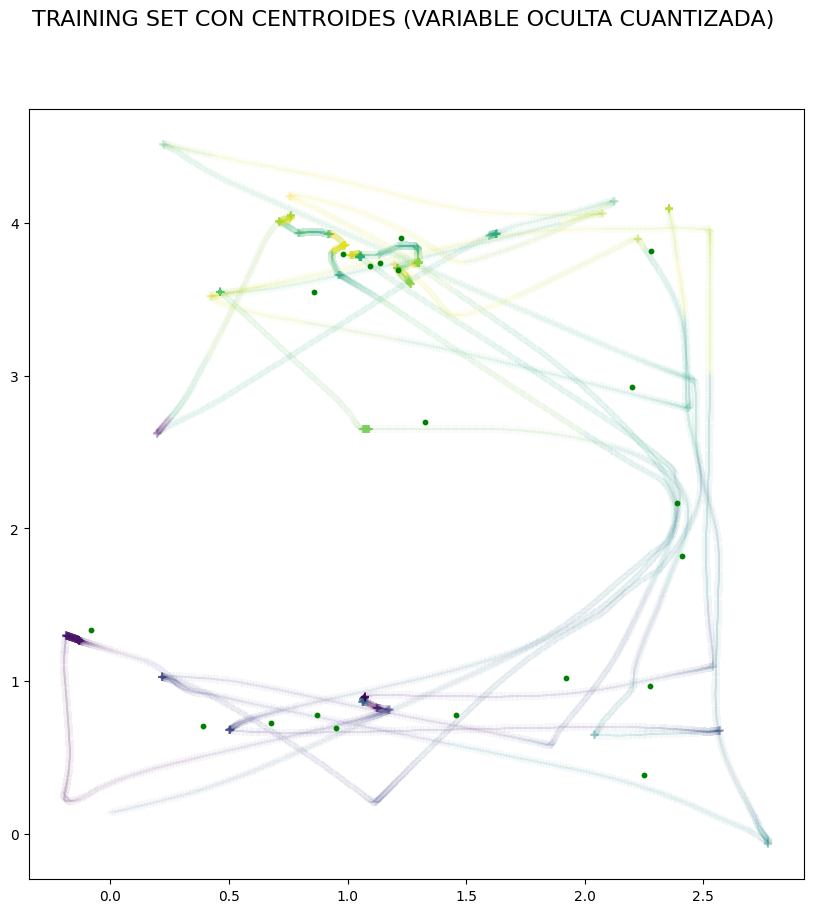

In [14]:

paths= viterbi(obs2_windowed,Modelo2,Modelo2.PI)  #Modelo 2 uses obs2
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('TRAINING SET CON CENTROIDES (VARIABLE OCULTA CUANTIZADA)', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)





cords3=path_to_xy(np.arange(0,Modelo1.A.shape[0]),cc)
ax1.scatter(x= cords3.xcuant, y=cords3.ycuant ,marker='.',s=40,c='g')



In [15]:
# PARA MOSTRAR DIRECCIÓN DE CENTROIDES  VARIABLE OCULTA CUANTIZADA
def plot_cc_arrow(cc):
    fig=plt.figure(figsize=(10,10))
    for c in cc:
        ang=c[2]*180/math.pi
        

        plt.plot(c[0], c[1], marker=(3, 1,ang + 90 ), markersize=10,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2])), c[1]-(.01*np.sin(c[2])), marker=(1, 1,ang+ 90), markersize=25,c='green', linestyle='--')
        #plt.plot(c[0]-(.01*np.cos(c[2]+.5*math.pi)), c[1]-(.01*np.sin(c[2]+.5*math.pi)), marker=(1, 1,ang), markersize=25,c='blue', linestyle='--')

    #plt.xlim([0,4])
    #plt.ylim([0,4])

    plt.show()

<Figure size 1000x1000 with 0 Axes>

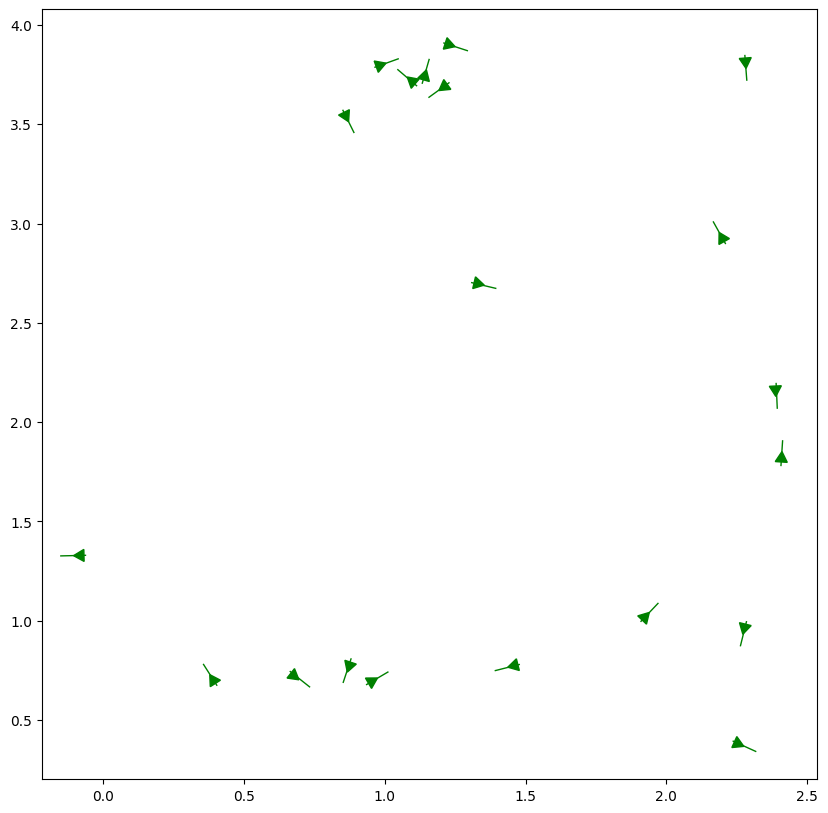

In [16]:
fig=plt.figure(figsize=(10,10))
plot_cc_arrow(cc)


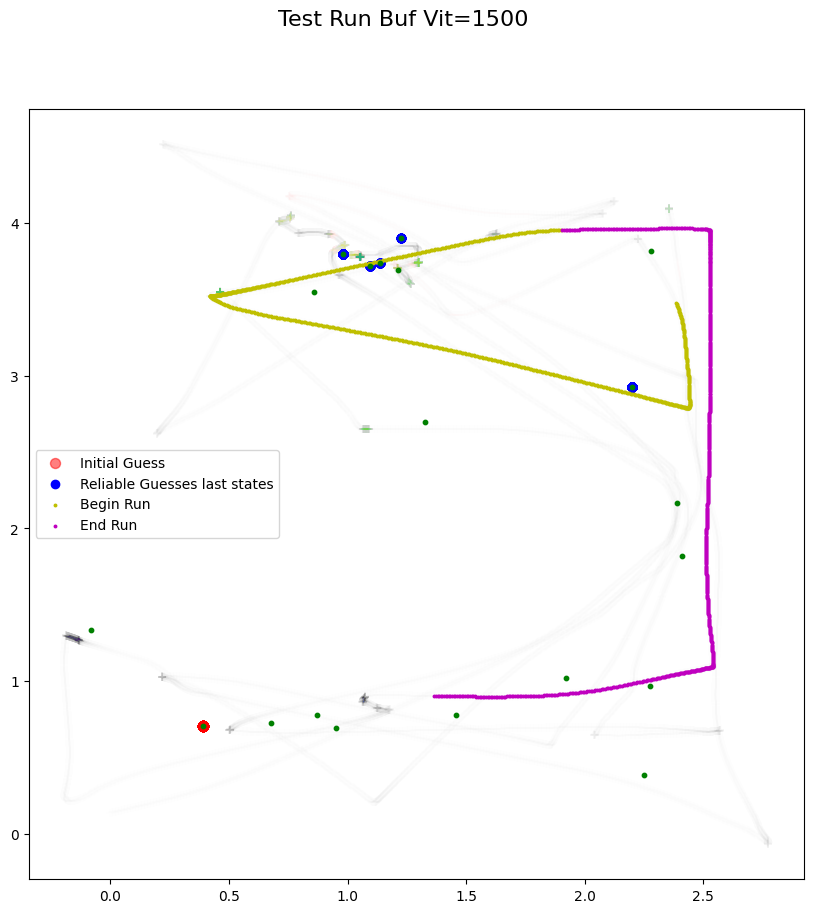

In [23]:
cc=ccxyth.sort_values('norm').iloc[:,:3].values
paths= viterbi(obs2_windowed,Modelo2,Modelo2.PI)  #Modelo 2 uses obs2
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=1500', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.00313)  ###Real Centroids  ( ESTIMACION ESPACIO ESTADO, REAL)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 ,label= 'Initial Guess ') 

ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='b' ,alpha=1, label= 'Reliable Guesses last states')




ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y' , label='Begin Run')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m' , label= 'End Run' )
cords3=path_to_xy(np.arange(0,Modelo1.A.shape[0]),cc)
ax1.scatter(x= cords3.xcuant, y=cords3.ycuant ,marker='.',s=40,c='g')
plt.legend()


In [24]:

## TIPICAMENTE VALORES TAN BAJOS DE BUFER DE VITERBI SON USADOS PARA OBSERVACIONES MAS CARAS ( imágenes y nubes de puntos)
## PERO ES EL MISMO FUNCIONAMIENTO

buf_vit=60
for i in range(1):
    
    
    obs_windowed= obs[indice:indice+buf_vit]
    obs2_windowed= obs2[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    path2= viterbi(obs2_windowed,Modelo2,Modelo2.PI)
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat), accuracy(ytrue,yhat2))

2553
1.0 1.0


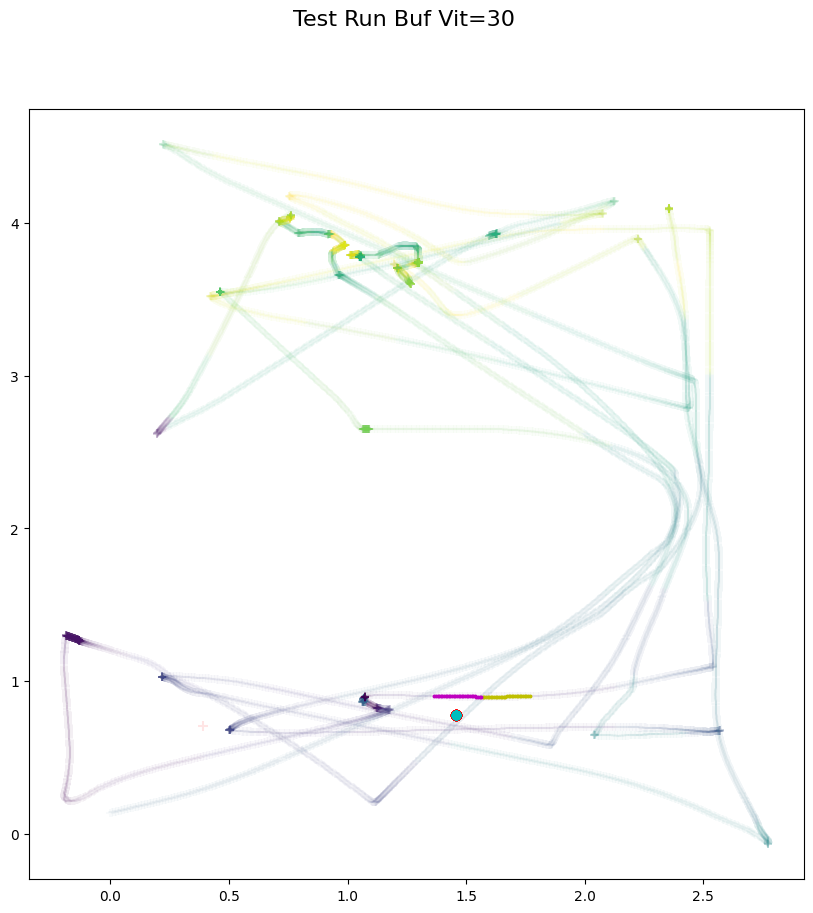

In [25]:
paths= viterbi(obs2_windowed,Modelo2,Modelo2.PI)
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=30', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52,alpha=.1 )
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='c' ,alpha=.5)
ax1.scatter(x=cords1delay.xcuant, y=cords1delay.ycuant, marker='+',c='c' ,alpha=.1)



ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m')



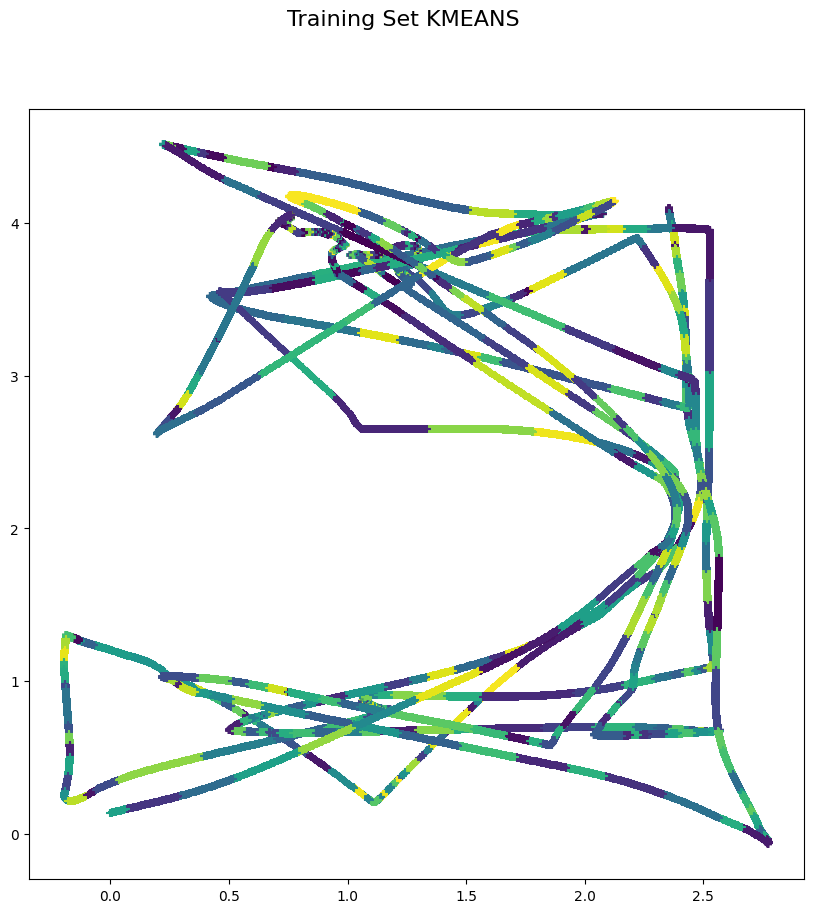

In [31]:
### COLOR SEGUN SIMBOLO OBSERVADO  CUANTIZACION VARIABLE OBSERVABLE

fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set KMEANS', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Vk)


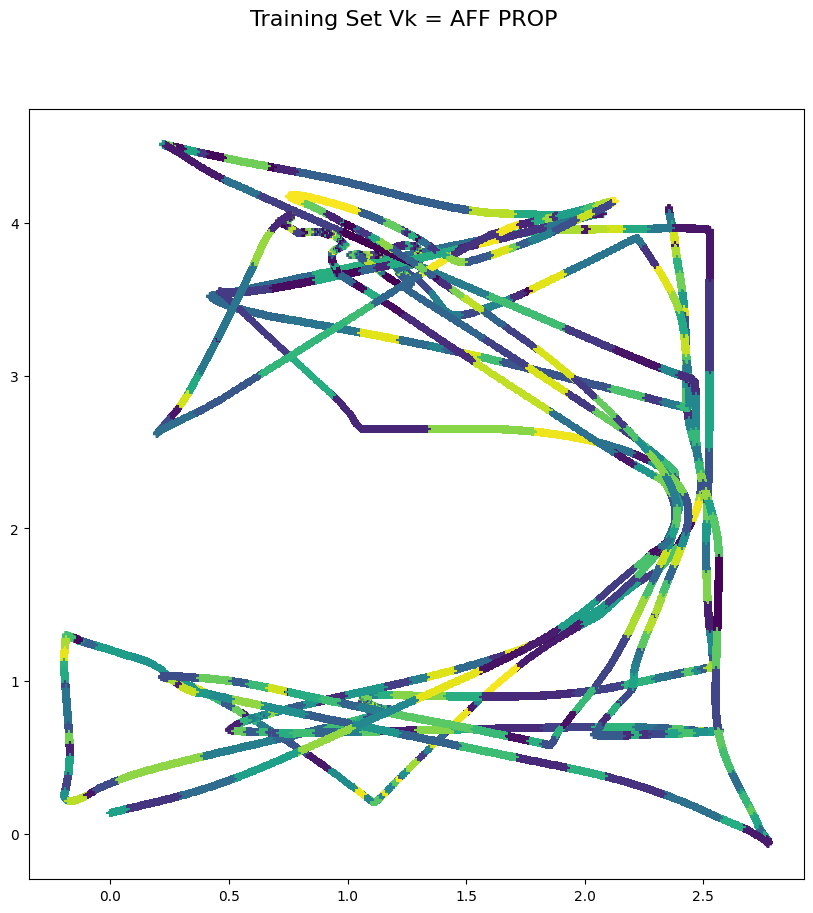

In [32]:


fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set Vk = AFF PROP', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Vk_aff)


In [29]:
ccxyth=cc
graphe= Markov_A_2_grafo(A,ccxyth)
ruta=dijkstra(1,6,graphe)


RUTA CALCULADA 



### SECUENCIA DE NODOS A NAVEGAR DADO POSICION ACTUAL Y META   
### ATRACTORES VIRTUALES

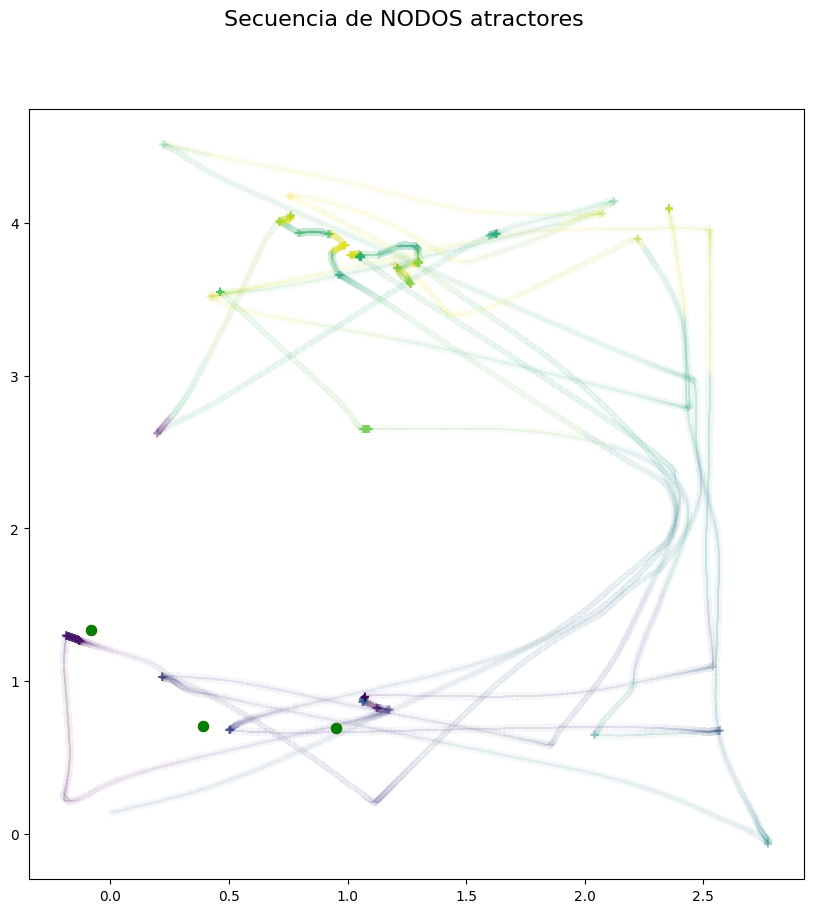

In [35]:
#ruta.append(nodofinal)
path=np.array(ruta)
path
cords_path= path_to_xy(path,cc)
#cords_path= path_to_xy(path[:int(len(path)/2)],cc)

cords_path2= path_to_xy(path,cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Secuencia de NODOS atractores', fontsize=16)
ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords_path.xcuant, y=cords_path.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_path2.xcuant, y=cords_path2.ycuant, marker='o',c='g',s=52 )


In [36]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk.value_counts())



lec_deseada=aux.index[0]   ###CHOOSING MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

((721,), 44)

44


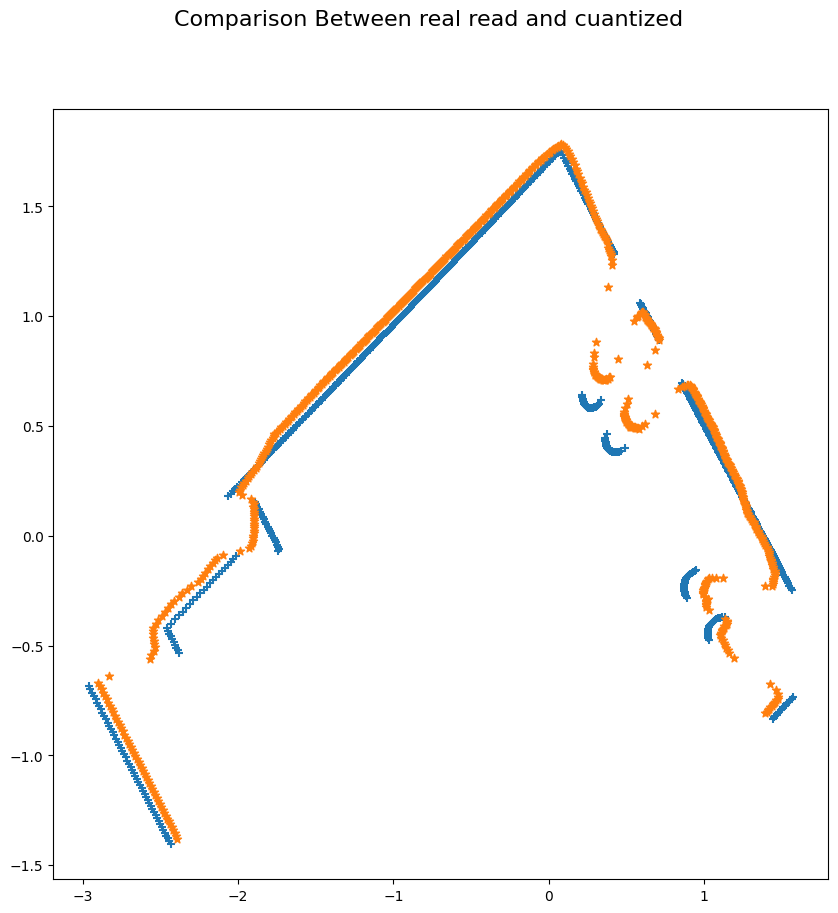

In [37]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print(np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin())
lec_leida= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
CORDS['xx'],CORDS['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real read and cuantized', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDS.xx,y=CORDS.yy,marker='*')

In [38]:
lecs=data[data.Vk==lec_leida]
lecs.shape

(295, 727)

In [39]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk==lec_leida].sample(n=10,axis=0).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

44


44


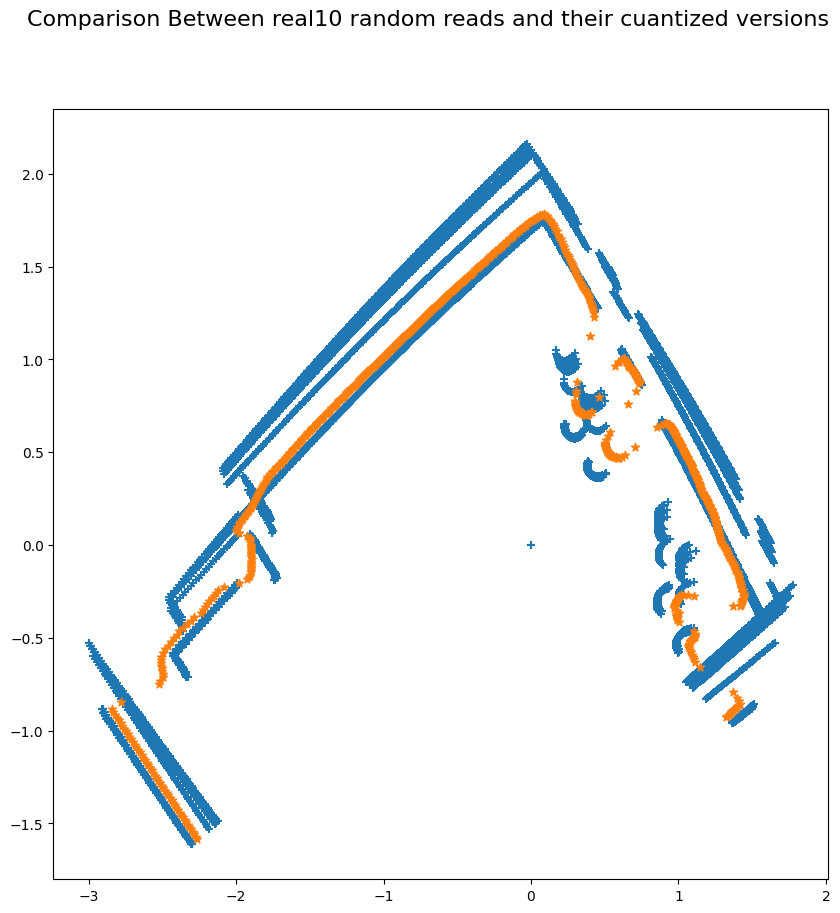

In [40]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs

CORDSVK=pd.DataFrame()
CORDSVK['xx'],CORDSVK['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real10 random reads and their cuantized versions', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDSVK.xx,y=CORDSVK.yy,marker='*')
print(lec_leida)

# LO QUE SIGUE TAL VEZ NO SEA TAN IMPORTANTE PARA DANIEL
## Correciones de odometría segun el símbolo
## Estadístico
## ICP ODOMETRIA LASER
## AFF PROP

# Pro sobre todo no se si funcione sin algunas partes más jeje


In [41]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk.value_counts())


 
lec_deseada=aux.index[4]   ###CHOOSING 5th MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

((721,), 86)

In [ ]:


cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print(np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin())
lec_leida= np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
CORDS['xx'],CORDS['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real and quantized reads KMEANS', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDS.xx,y=CORDS.yy,marker='*')

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk==lec_leida].sample(n=10,axis=0 , replace=True).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']
vec_obs=ccvk[np.power(lec.T-ccvk,2).sum(axis=1,keepdims=True).argmin()]
cordsy, cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs

CORDSVK=pd.DataFrame()
CORDSVK['xx'],CORDSVK['yy']=cordsx,cordsy


fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between10 random reads and their cuantized version ' , fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x=CORDSVK.xx,y=CORDSVK.yy,marker='*')

In [ ]:
############################################################################################


In [ ]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk_aff.value_counts())



lec_deseada=aux.index[0]   ###CHOOSING MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk_aff==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

In [ ]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print("COMPARING AFF PROP READINGS NO centroid")

lec_leida= (int)( clf.predict(lec.reshape(1, -1)))
print(lec_leida)

fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')

CORDS_ORIG = pd.DataFrame((cordsx,cordsy))
CORDS_ORIG=CORDS_ORIG.T
CORDS_ORIG.columns=['x','y']

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk_aff==lec_leida].sample(n=20,axis=0).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real 20 random reads and their cuantized versions AFF_PROP', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x= CORDS_ORIG.x, y=CORDS_ORIG.y,marker='+')

print(lec_leida)

In [ ]:
#lec=np.load('lec.npy')
aux=pd.DataFrame(data.Vk_aff.value_counts())



lec_deseada=aux.index[3]   ###CHOOSING 3rd MOST FREQUENT OBSERVATION SYMBOL

lec=data[data.Vk_aff==lec_deseada].sample(n=1,axis=0).iloc[:,:-6].values.ravel()


start_ang=-240/2*np.pi/180
stop_ang= 240/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(lec))
lec.shape,lec_deseada

In [ ]:
cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
CORDS=pd.DataFrame((cordsx,cordsy))
CORDS=CORDS.T
CORDS.columns=['x','y']
print("COMPARING AFF PROP READINGS NO centroid")

lec_leida= (int)( clf.predict(lec.reshape(1, -1)))
print(lec_leida)

fig = plt.figure(figsize=(10,10))


ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
CORDS_ORIG = pd.DataFrame((cordsx,cordsy))
CORDS_ORIG=CORDS_ORIG.T
CORDS_ORIG.columns=['x','y']

In [ ]:
auxy , auxx =np.array([0,0]),np.array([0,0])
start_ang=-250/2*np.pi/180
stop_ang= 250/2*np.pi/180
angs=np.linspace(start_ang,stop_ang,num=len(vec_obs))


lecs=data[data.Vk_aff==lec_leida].sample(n=20,axis=0).iloc[:,:-6]

for  vec_obs in lecs.values.tolist():
    cordsy,cordsx= np.cos(angs) *  vec_obs ,  np.sin(angs) *  vec_obs
    auxy,auxx=np.concatenate((auxy,cordsy)),np.concatenate((auxx,cordsx))
print(lec_leida)    

In [ ]:

CORDS=pd.DataFrame((auxx,auxy))
CORDS=CORDS.T
CORDS.columns=['x','y']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison Between real 20 random reads and their cuantized versions AFF_PROP', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+')
ax1.scatter(x= CORDS_ORIG.x, y=CORDS_ORIG.y,marker='+')

print(lec_leida)

In [ ]:
data.Vk.hist()

In [ ]:
data.Vk_aff.hist()

In [ ]:
aux=pd.DataFrame(data.Vk.value_counts())
xy=data[['x','y','Vk','Y']][data.Vk==(aux.index[0]  ) ]
CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+', c=CORDS.Y),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk.value_counts())
xy=data[['x','y','theta','Vk','Y']][data.Vk==aux.index[0]]
xy= xy.append(data[['x','y','theta','Vk','Y']][data.Vk==aux.index[1]])
xy= xy.append(data[['x','y','theta','Vk','Y']][data.Vk==aux.index[2]])


CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y, c=CORDS.Vk,marker='+',cmap='Set1'),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk_aff.value_counts())
xy=data[['x','y','Vk_aff','Y']][data.Vk_aff==(aux.index[0]  ) ]
CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y,marker='+', c=CORDS.Y),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk_aff.value_counts())
xy=data[['x','y','theta','Vk_aff','Y']][data.Vk_aff==aux.index[0]]
xy= xy.append(data[['x','y','theta','Vk_aff','Y']][data.Vk_aff==aux.index[1]])
xy= xy.append(data[['x','y','theta','Vk_aff','Y']][data.Vk_aff==aux.index[2]])


CORDS=xy
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.scatter(x= CORDS.x, y=CORDS.y, c=CORDS.Vk_aff,marker='+',cmap='Set1'),xy.describe()

In [ ]:
aux=pd.DataFrame(data.Vk.value_counts())
cents=[]
for i in aux.index[:3]:
    print (data[data.Vk==i][['x','y','theta']].describe())
    cents.append(data[data.Vk==i][['x','y','theta']].mean(axis=0))

aux=pd.DataFrame(data.Vk_aff.value_counts())
cents_aff=[]
for i in aux.index[:3]:
    print (data[data.Vk_aff==i][['x','y','theta']].describe())
    cents_aff.append(data[data.Vk_aff==i][['x','y','theta']].mean(axis=0))

In [ ]:
cents_aff=np.asarray(cents_aff)

In [ ]:
cents_aff

In [ ]:
cents

In [ ]:
def plot_lec(lec):
    cordsy, cordsx= np.cos(angs) *  lec ,  np.sin(angs) *  lec
    CORDS=pd.DataFrame((cordsx,cordsy))
    CORDS=CORDS.T
    CORDS.columns=['x','y']
    plt.scatter(CORDS.x , CORDS.y)
    return CORDS.T

In [ ]:

lec= data.iloc[1000,0:721].values
lec1= data.iloc[1111,0:721].values

In [ ]:
xy=plot_lec(lec1).values

In [ ]:
xy_ref=plot_lec(lec).values

In [ ]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

In [ ]:
xy.shape

In [ ]:

plot_data(xy, xy_ref, "new read:P ", "Q: reference")


In [ ]:

plot_data(xy, xy_ref, "P: moved data", "Q: true data")


In [ ]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

In [ ]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

center_of_P, P_centered = center_data(xy)
center_of_Q, Q_centered = center_data(xy_ref)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

In [ ]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

In [ ]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

In [ ]:
def compute_cross_covariance(P, Q, correspondences):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        
        cov +=  q_point.dot(p_point.T)
        
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

In [ ]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U.dot(V_T)
t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

In [ ]:
print(t_found)
print(R_found)
P_corrected = R_found.dot(xy) + t_found
ax = plot_data(P_corrected, xy_ref, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - xy_ref))

In [ ]:

plot_data(xy, xy_ref, "P: moved data", "Q: true data")


In [ ]:
xy=P_corrected

In [ ]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

P_values, norm_values, corresp_values = icp_svd(xy, xy_ref)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], xy_ref, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

In [ ]:
correspondences = get_correspondence_indices(xy, xy_ref)
ax = plot_data(xy, xy_ref, "Moved data", "True data")
draw_correspondeces(xy, xy_ref, correspondences, ax)
plt.show()

In [ ]:
def dR(theta):
    return np.array([[-np.sin(theta), -np.cos(theta)],
                     [np.cos(theta),  -np.sin(theta)]])

def R(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]]).reshape((2,2))

In [ ]:
def jacobian(x, p_point):
    theta = x[2]
    J = np.zeros((2, 3))
    J[0:2, 0:2] = np.identity(2)
    J[0:2, [2]] = dR(0).dot(p_point)
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation.dot(p_point) + translation
    return prediction - q_point

In [ ]:
def prepare_system(x, P, Q, correspondences, kernel=lambda distance: 1.0):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        e = error(x, p_point, q_point)
        weight = kernel(e) # Please ignore this weight until you reach the end of the notebook.
        J = jacobian(x, p_point)
        H += weight * J.T.dot(J)
        g += weight * J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_least_squares(P, Q, iterations=30, kernel=lambda distance: 1.0):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = np.arctan2(np.sin(x[2]), np.cos(x[2])) # normalize angle
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_copy = rot.dot(P.copy()) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_least_squares(xy, xy_ref)
plot_values(chi_values, label="chi^2")
print(chi_values)

In [ ]:
correspondences = get_correspondence_indices(xy, xy_ref)
ax = plot_data(xy, xy_ref, "Moved data", "True data")
draw_correspondeces(xy, xy_ref, correspondences, ax)
plt.show()

In [ ]:
correspondences = get_correspondence_indices(P_values[-1], xy_ref)
ax = plot_data(P_values[-1], xy_ref, "Moved data", "True data")
draw_correspondeces(P_values[-1], xy_ref, correspondences, ax)
plt.show()

In [ ]:
def compute_normals(points, step=1):
    normals = [np.array([[0, 0]])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        dx = next_point[0] - prev_point[0] 
        dy = next_point[1] - prev_point[1]
        normal = np.array([[0, 0],[-dy, dx]])
        normal = normal / np.linalg.norm(normal)
        normals.append(normal[[1], :])  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([[0, 0]]))
    return normals, normals_at_points

def plot_normals(normals, ax):
    label_added = False
    for normal in normals:
        if not label_added:
            ax.plot(normal[:,0], normal[:,1], color='grey', label='normals')
            label_added = True
        else:
            ax.plot(normal[:,0], normal[:,1], color='grey')
    ax.legend()
    return ax

Q_normals, Q_normals_to_draw = compute_normals(xy_ref)
ax = plot_data(None, xy_ref, None, 'Q')
ax = plot_normals(Q_normals_to_draw, ax)
plt.show()

In [ ]:
from sympy import init_printing, symbols, Matrix, cos as s_cos, sin as s_sin, diff
init_printing(use_unicode = True)

def RotationMatrix(angle):
    return Matrix([[s_cos(angle) , -s_sin(angle)], [s_sin(angle), s_cos(angle)]])

x, y, theta, n_x, n_y, p_x, p_y = symbols('x, y, \\theta, n_x, n_y, p_x, p_y')
t = Matrix([[x], [y]])
X = Matrix([x,y,theta])
n = Matrix([[n_x],[n_y]])
p = Matrix([[p_x], [p_y]])

error_point = RotationMatrix(theta) * p + t
error_normal = n.dot(RotationMatrix(theta) * p + t)

display()
J_point = diff(error_point, X).reshape(3,2).transpose()
J_normal = diff(error_normal, X).reshape(3,1).transpose()


In [ ]:
import sympy


In [ ]:
from sympy import init_printing, symbols, Matrix, cos as s_cos, sin as s_sin, diff
init_printing(use_unicode = True)

def RotationMatrix(angle):
    return Matrix([[s_cos(angle) , -s_sin(angle)], [s_sin(angle), s_cos(angle)]])

x, y, theta, n_x, n_y, p_x, p_y = symbols('x, y, \\theta, n_x, n_y, p_x, p_y')
t = Matrix([[x], [y]])
X = Matrix([x,y,theta])
n = Matrix([[n_x],[n_y]])
p = Matrix([[p_x], [p_y]])

error_point = RotationMatrix(theta) * p + t
error_normal = n.dot(RotationMatrix(theta) * p + t)

display()
J_point = diff(error_point, X).reshape(3,2).transpose()
J_normal = diff(error_normal, X).reshape(3,1).transpose()


In [ ]:
def prepare_system_normals(x, P, Q, correspondences, Q_normals):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        normal = Q_normals[j]
        e = normal.dot(error(x, p_point, q_point))
        J = normal.dot(jacobian(x, p_point))
        H += J.T.dot(J)
        g += J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_normal(P, Q, Q_normals, iterations=4):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_latest = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_latest, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system_normals(x, P, Q, correspondences, Q_normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = np.arctan2(np.sin(x[2]), np.cos(x[2])) # normalize angle
        chi_values.append(chi.item(0)) # add error to list of errors
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_latest = rot.dot(P.copy()) + t
        P_values.append(P_latest)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_normal(xy, xy_ref, Q_normals)
plot_values(chi_values, label="chi^2")

In [ ]:
P_values[-1].shape

In [ ]:
correspondences = get_correspondence_indices(P_values[-1], xy_ref)
ax = plot_data(P_values[-1], xy_ref, "Moved data", "True data")
draw_correspondeces(P_values[-1], xy_ref, correspondences, ax)
plt.show()

In [ ]:
P_values, chi_values, corresp_values = icp_normal(xy, xy_ref, Q_normals)

In [ ]:
import math
def plot_cc_arrow(cc):
    for c in cc:
        ang=c[2]*180/math.pi
        plt.plot(c[0], c[1], marker=(3, 1,ang+.5*math.pi ), markersize=10,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2]+math.pi/2)), c[1]-(.01*np.sin(c[2]+math.pi/2)), marker=(1, 1,ang+.5*math.pi), markersize=25,c='green', linestyle='--')

    #plt.xlim([0,4])
    #plt.ylim([0,4])

    plt.show()

In [ ]:
plot_cc_arrow(cc)

In [ ]:
cc=ccxyth



x=np.linspace(0,.4)
fig = plt.figure(figsize=(10,10))
fig.suptitle('Centroids POSE', fontsize=16)
euclD=np.zeros((N,N,1))
ss= np.arange(len(A))
for s1 in ss:
    for s2 in ss:
        if (s1!=s2)and (A[s1,s2]!=0):# and (np.linalg.norm(ccxyth[s1,:2]-ccxyth[s2,:2])<1)   :#and(s1==s or s2==s)
            xvalues=[ccxyth[s1,0],ccxyth[s2,0]]
            yvalues=[ccxyth[s1,1],ccxyth[s2,1]]
            euclD[s1,s2]=np.linalg.norm(ccxyth[s1,:2]-ccxyth[s2,:2])

            ax1 = fig.add_subplot(111)

            plt.plot(xvalues,yvalues ,alpha=.4 ,c='b' )
         
            scatter= ax1.scatter(x= ccxyth[s1,0], y=ccxyth[s1,1],c='b' ,marker='.',s=100)
            scatter= ax1.scatter(x= ccxyth[s2,0], y=ccxyth[s2,1],c='b' ,marker='.',s=100)
            #scatter= ax1.scatter(x= trans[s1,s2,0], y=trans[s1,s2,1],c='b' ,marker='|',s=140)
for c in cc:
        ang=c[2]*180/math.pi
        plt.plot(c[0], c[1], marker=(3, 1,ang - 90 ), markersize=20,c='green', linestyle='None')
        plt.plot(c[0]-(.01*np.cos(c[2])), c[1]-(.01*np.sin(c[2])), marker=(1, 1,ang- 90), markersize=50,c='green', linestyle='--')




In [ ]:
np.cos(cc[1,2]), np.sin(cc[1,2])

In [ ]:
cc[1,2]

In [ ]:

import math
math.pi

In [ ]:
cc

In [ ]:
cc=ccxyth.sort_values('norm').iloc[:,:3].values
cc

In [ ]:
cc=np.load('ccxyth.npy')

In [ ]:
cc

In [ ]:
obs2=np.asarray([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 42, 42, 42, 42, 42, 42, 42, 23, 48, 48, 48, 48, 48, 48])


In [ ]:
Modelo2

In [ ]:

viterbi(obs2[-20:-10],Modelo2,PI)

In [ ]:
from utils_hmm import forw_alg


In [ ]:
forw_alg(obs2[5:10],Modelo2)

In [ ]:
obs2[0]

In [ ]:
Modelo2.B.shape

In [ ]:
Modelo2.B[4,:]

In [ ]:
buf_vit=150
indice= int(np.random.rand()*(len(obs)-2*buf_vit))
for i in range(1):
    
   
    obs_windowed= obs[indice:indice+buf_vit]
    obs2_windowed= obs_aff[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    #PATH from Model 1 KMEANS CC's obs
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    
    ##PATH FROM MODEL 2 WICH NEEDS AFF PORP QUANT OBS
    path2= viterbi(obs2_windowed,Modelo2,Modelo2.PI)
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat), accuracy(ytrue,yhat2))


In [ ]:
path, est_windowed, path2

In [ ]:
num_particles=10
particles=np.zeros((3,num_particles))
particles[:,0]=cc[np.argmax(Modelo2.B[:,obs2_windowed[0]])]
particles[:,1]=cc[np.argmax(Modelo1.B[:,obs_windowed[0]])]
particles[:,2]=cc[np.argmax(Modelo1.B[:,obs_windowed[-1]])]
particles[:,3]=cc[np.argmax(Modelo2.B[:,obs2_windowed[-1]])]
particles[:,4]=cc[int(path2[0])]
particles[:,5]=cc[int(path2[-1])]


In [ ]:
img = plt.imread("map.png")
fig, ax = plt.subplots(1,1,figsize=(10,10))
x = range(300)
ax.imshow(img, extent=[-0.3, 3.5,-1, 5])
ax.scatter(x=particles[:,0],y=particles[:,1])


In [ ]:
#next Step
indice+= buf_vit 
for i in range(1):
    
   
    obs_windowed= obs[indice:indice+buf_vit]
    obs2_windowed= obs_aff[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    #PATH from Model 1 KMEANS CC's obs
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI) #############################NO MANTAIN MODE
    
    ##PATH FROM MODEL 2 WICH NEEDS AFF PORP QUANT OBS
    path2= viterbi(obs2_windowed,Modelo2,Modelo2.PI)###########################NO MANTAIN MODE 
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat), accuracy(ytrue,yhat2))


In [ ]:
num_particles1=10
particles1=np.zeros((3,num_particles1))
particles1[:,0]=cc[np.argmax(Modelo2.B[:,obs2_windowed[0]])]
particles1[:,1]=cc[np.argmax(Modelo1.B[:,obs_windowed[0]])]
particles1[:,2]=cc[np.argmax(Modelo1.B[:,obs_windowed[-1]])]
particles1[:,3]=cc[np.argmax(Modelo2.B[:,obs2_windowed[-1]])]
particles1[:,4]=cc[int(path2[0])]
particles1[:,5]=cc[int(path2[-1])]
particles1[:,6]=cc[np.argmax(Modelo2.B[:,obs2_windowed[70]])]

In [ ]:
particles=np.concatenate((particles,particles1))

In [ ]:
img = plt.imread("map.png")
fig, ax = plt.subplots(1,1,figsize=(10,10))
x = range(300)
ax.imshow(img, extent=[-0.3, 3.5,-1, 5])
ax.scatter(x=particles[:,0],y=particles[:,1])


In [ ]:
xy_ref=plot_lec(ccvk[np.argmin(np.linalg.norm((lec-ccvk),axis=1))]).values

In [ ]:
xy=plot_lec(lec).values

In [ ]:
Q_normals, Q_normals_to_draw = compute_normals(xy_ref)
ax = plot_data(None, xy_ref, None, 'Q')
ax = plot_normals(Q_normals_to_draw, ax)
plt.show()

In [ ]:

P_values, chi_values, corresp_values = icp_normal(xy, xy_ref, Q_normals)
plot_values(chi_values, label="chi^2")

In [ ]:
correspondences = get_correspondence_indices(P_values[-1], xy_ref)
ax = plot_data(P_values[-1], xy_ref, "Moved data", "True data")
draw_correspondeces(P_values[-1], xy_ref, correspondences, ax)
plt.show()

In [ ]:
xy_ref[0].shape

In [ ]:
particles=np.zeros((3,len(ccxyth)))

In [ ]:
particles=ccxyth[:,:2]

In [ ]:
img = plt.imread("map.png")
fig, ax = plt.subplots(1,1,figsize=(10,10))
x = range(300)
ax.imshow(img, extent=[-0.3, 3.5,-1, 5])
ax.scatter(x=particles[:,0],y=particles[:,1])


In [ ]:
img = plt.imread("map.png")
fig, ax = plt.subplots(1,1,figsize=(10,10))
x = range(300)
#ax.imshow(img, extent=[-1, 3, -1.5, 2.5])
